# Reinforcement Learning Project: Simulating the Board Game "Ghosts" by Alex Randolph

Creating a reinforcement learning project to simulate the board game *Ghosts* involves several steps. This guide will cover the game’s rules and logic, and outline a step-by-step approach to implementing a reinforcement learning agent using Gym and Q-Learning.

## Game Rules and Logic

### Game Setup
- **Board:** The game is played on a 6x6 board.
- **Players:** Each player has 8 ghosts: 4 good ghosts and 4 evil ghosts. The identity of each ghost is hidden from the opponent.
- **Placement:** Players arrange their ghosts in the back two rows on their side of the board.

### Game Objective
A player wins by:
1. Capturing all four of the opponent's good ghosts.
2. Having the opponent capture all four of their evil ghosts.
3. Moving one of their good ghosts to one of the opponent's corner exits.

### Game Play
- **Turns:** Players take turns moving one ghost per turn.
- **Movement:** Ghosts can move one square in any direction (up, down, left, right) but not diagonally.
- **Capturing:** A ghost can capture an opponent's ghost by moving into its square, revealing the captured ghost's identity.


In [154]:
import gym
from gym import spaces
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import ListedColormap
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


In [155]:
# Actions
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
PLACE_BLUE = 4
PLACE_RED = 5
CAPTURE_UP = 6
CAPTURE_RIGHT = 7
CAPTURE_DOWN = 8
CAPTURE_LEFT = 9

ACTIONS = [UP, RIGHT, DOWN, LEFT, PLACE_BLUE, PLACE_RED, CAPTURE_UP, CAPTURE_RIGHT, CAPTURE_DOWN, CAPTURE_LEFT]

# Update ACTION_NAMES
ACTION_NAMES = {
    UP: "Move Up",
    RIGHT: "Move Right",
    DOWN: "Move Down",
    LEFT: "Move Left",
    PLACE_BLUE: "Place Blue Piece",
    PLACE_RED: "Place Red Piece",
    CAPTURE_UP: "Capture Up",
    CAPTURE_RIGHT: "Capture Right",
    CAPTURE_DOWN: "Capture Down",
    CAPTURE_LEFT: "Capture Left"
}

# Define possible spaces
EMPTY = 0
PLAYER_BLUE = 1
PLAYER_RED = 2
OPPONENT_BLUE = 3
OPPONENT_RED = 4


# Define mappings from space values to names
SPACE_NAMES = {
    EMPTY: "Empty",
    PLAYER_BLUE: "Player Blue",
    PLAYER_RED: "Player Red",
    OPPONENT_BLUE: "Opponent Blue",
    OPPONENT_RED: "Opponent Red"
}

In [156]:
import gym
import numpy as np
from gym import spaces


class GhostsEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(GhostsEnv, self).__init__()

        # Size of the board is size x size
        self.size = 6

        # Action space is tuple: (action, x, y, player)
        # action: 0-3 (move up, right, down, left), 5 (place blue), 6 (place red), 7-10 (capture up, right, down, left)
        self.action_space = spaces.Tuple((spaces.Discrete(11), spaces.Discrete(self.size), spaces.Discrete(self.size), spaces.Discrete(2)))

        # Reward
        self.reward = 0

        # Initialize the game state
        self.reset()

    def reset(self):
        # Initialize the board
        self.board = np.zeros((self.size, self.size), dtype=int)

        # Reset phase (0: placement, 1: movement)
        self.phase = 0

        # Reset ghost counts
        self.player_blue_count = 0
        self.opponent_blue_count = 0
        self.player_red_count = 0
        self.opponent_red_count = 0

        return self.board
    
    def legal_placement_actions(self, player):
        actions = []
        if player == 0:  # Player's turn
            rows = [4, 5]
            valid_cells = [(y, x) for y in rows for x in range(1, self.size - 1) if self.board[y, x] == 0]
        else:  # Opponent's turn
            rows = [0, 1]
            valid_cells = [(y, x) for y in rows for x in range(1, self.size - 1) if self.board[y, x] == 0]

        if player == 0:
            if self.player_blue_count < 4:
                for x, y in valid_cells:
                    actions.append((4, x, y, player))  # Place blue ghost
            if self.player_red_count < 4:
                for x, y in valid_cells:
                    actions.append((5, x, y, player))  # Place red ghost
        else:
            if self.opponent_blue_count < 4:
                for x, y in valid_cells:
                    actions.append((4, x, y, player))  # Place blue ghost
            if self.opponent_red_count < 4:
                for x, y in valid_cells:
                    actions.append((5, x, y, player))  # Place red ghost

        return actions

    def legal_movement_actions(self, player):
        actions = []
        for y in range(self.size):
            for x in range(self.size):
                if (player == 0 and self.board[x, y] in [PLAYER_BLUE, PLAYER_RED]) or (player == 1 and self.board[x, y] in [OPPONENT_BLUE, OPPONENT_RED]):
                    # Check all four directions for movement and capture
                    if y > 0:
                        if self.board[x, y-1] == EMPTY:
                            actions.append((LEFT, x, y, player))
                        elif player == 0 and self.board[x, y-1] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_LEFT, x, y, player))
                        elif player == 1 and self.board[x, y-1] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_LEFT, x, y, player))
                    
                    if y < self.size - 1:
                        if self.board[x, y+1] == EMPTY:
                            actions.append((RIGHT, x, y, player))
                        elif player == 0 and self.board[x, y+1] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_RIGHT, x, y, player))
                        elif player == 1 and self.board[x, y+1] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_RIGHT, x, y, player))
                    
                    if x < self.size - 1:
                        if self.board[x+1, y] == EMPTY:
                            if player == 0:
                                actions.append((DOWN, x, y, player))
                            else:
                                actions.append((DOWN, x, y, player))
                        elif player == 0 and self.board[x+1, y] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_DOWN, x, y, player))
                        elif player == 1 and self.board[x+1, y] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_DOWN, x, y, player))
                    
                    if x > 0:
                        if self.board[x-1, y] == EMPTY:
                            if player == 0:
                                actions.append((UP, x, y, player))
                            else:
                                actions.append((UP, x, y, player))
                        elif player == 0 and self.board[x-1, y] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_UP, x, y, player))
                        elif player == 1 and self.board[x-1, y] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_UP, x, y, player))
        
        return actions

    def step(self, action):

        self.reward = 0

        if self.phase == 0:
            self._place(action)
        else:
            self._take_action(action)

        player = action[3]

        done = self._is_done(player)
        reward = self._get_reward()

        return self.board, reward, done, {}

    def _place(self, action):
        action, x, y, player = action
        if player == 0:
            if action == 4:
                self.board[x, y] = PLAYER_BLUE
                self.player_blue_count += 1
            elif action == 5:
                self.board[x, y] = PLAYER_RED
                self.player_red_count += 1
        else:
            if action == 4:
                self.board[x, y] = OPPONENT_BLUE
                self.opponent_blue_count += 1
            elif action == 5:
                self.board[x, y] = OPPONENT_RED
                self.opponent_red_count += 1

    def _take_action(self, action):
        action, x, y, player = action
        if action in [UP, DOWN, LEFT, RIGHT]:
            self._move(x, y, action, player)
        elif action in [CAPTURE_UP, CAPTURE_DOWN, CAPTURE_LEFT, CAPTURE_RIGHT]:
            self._capture(x, y, action, player)

    def _move(self, x, y, direction, player):
        new_x, new_y = x, y
        if direction == UP:
            new_x = x - 1
        elif direction == DOWN:
            new_x = x + 1
        elif direction == LEFT:
            new_y = y - 1
        elif direction == RIGHT:
            new_y = y + 1

        if 0 <= new_x < self.size and 0 <= new_y < self.size and self.board[new_x, new_y] == EMPTY:
            self.board[new_x, new_y] = self.board[x, y]
            self.board[x, y] = EMPTY

    def _capture(self, x, y, direction, player):
        new_x, new_y = x, y
        if direction == CAPTURE_UP:
            new_x = x - 1
        elif direction == CAPTURE_DOWN:
            new_x = x + 1
        elif direction == CAPTURE_LEFT:
            new_y = y - 1
        elif direction == CAPTURE_RIGHT:
            new_y = y + 1

        if 0 <= new_x < self.size and 0 <= new_y < self.size:
            captured_piece = self.board[new_x, new_y]
            if (player == 0 and captured_piece in [OPPONENT_BLUE, OPPONENT_RED]) or \
               (player == 1 and captured_piece in [PLAYER_BLUE, PLAYER_RED]):
                self.board[new_x, new_y] = self.board[x, y]
                self.board[x, y] = EMPTY
                if captured_piece == OPPONENT_BLUE:
                    self.opponent_blue_count -= 1
                    self.reward = 10 if player == 0 else -10
                elif captured_piece == OPPONENT_RED:
                    self.opponent_red_count -= 1
                    self.reward = -10 if player == 0 else 10
                elif captured_piece == PLAYER_BLUE:
                    self.player_blue_count -= 1
                    self.reward = -10 if player == 0 else 10
                elif captured_piece == PLAYER_RED:
                    self.player_red_count -= 1
                    self.reward = 10 if player == 0 else -10

    def _get_reward(self):
        
        if self.phase == 0:
            return 0  # No reward during placement phase
        
        # Small negative reward for each move to encourage efficiency
        return self.reward - 0.1
    
    def _is_done(self, player):

        if self.phase == 0:
            if self.player_blue_count == 4 and self.player_red_count == 4 and self.opponent_blue_count == 4 and self.opponent_red_count == 4:
                self.phase = 1
                return 2
            return 2
        else:
            if self.player_blue_count == 0 or self.opponent_red_count == 0:
                if player == 0:
                    self.reward -= 100
                    return 1
                else:
                    self.reward += 100
                    return 1
            elif self.player_red_count == 0 or self.opponent_blue_count == 0:
                if player == 0:
                    self.reward += 100
                    return 0
                else:
                    self.reward -= -100
                    return 0
            
            # Check if there are blue player pieces on the opponent's angles
            if self.board[0, 0] == PLAYER_BLUE or self.board[0, self.size - 1] == PLAYER_BLUE:
                if player == 0:
                    self.reward += 100
                    return 0
                else:
                    self.reward -= 100
                    return 0
            if self.board[self.size - 1, 0] == OPPONENT_BLUE or self.board[self.size - 1, self.size - 1] == OPPONENT_BLUE:
                if player == 0:
                    self.reward -= 100
                    return 1
                else:
                    self.reward += 100
                    return 1
            return 2
            
                

    def render(self, mode='human'):
        print("\n " + " ".join([str(i) for i in range(self.size)]))
        for y in range(self.size):
            row = [str(y)]
            for x in range(self.size):
                if self.board[y, x] == EMPTY:
                    row.append(".")
                elif self.board[y, x] == PLAYER_BLUE:
                    row.append("B")
                elif self.board[y, x] == PLAYER_RED:
                    row.append("R")
                elif self.board[y, x] == OPPONENT_BLUE:
                    row.append("b")
                elif self.board[y, x] == OPPONENT_RED:
                    row.append("r")
            print(" ".join(row))
        print()
    
    def close(self):
        pass


Episode 400: Training in progress...


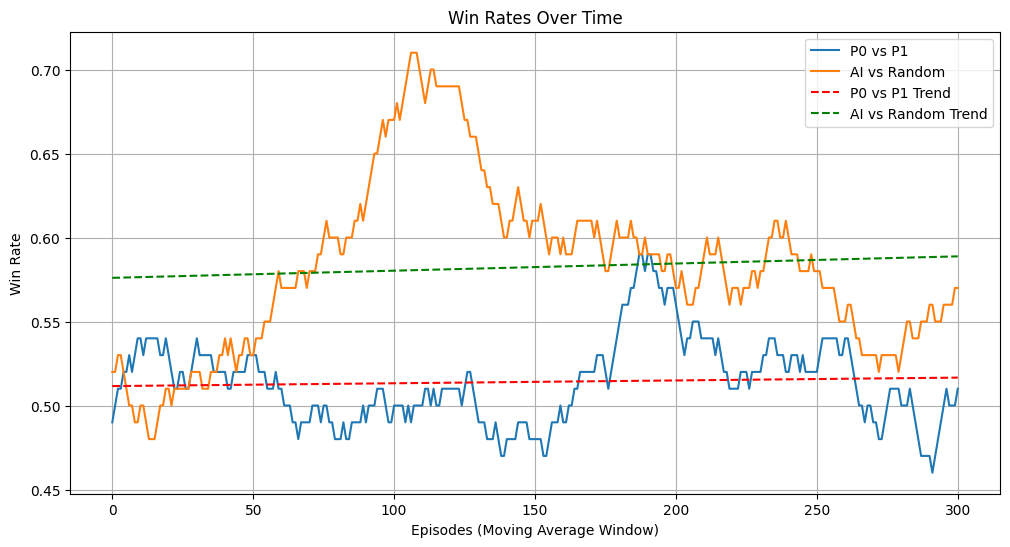

Recent win rate against random: 0.58
Episode 800: Training in progress...


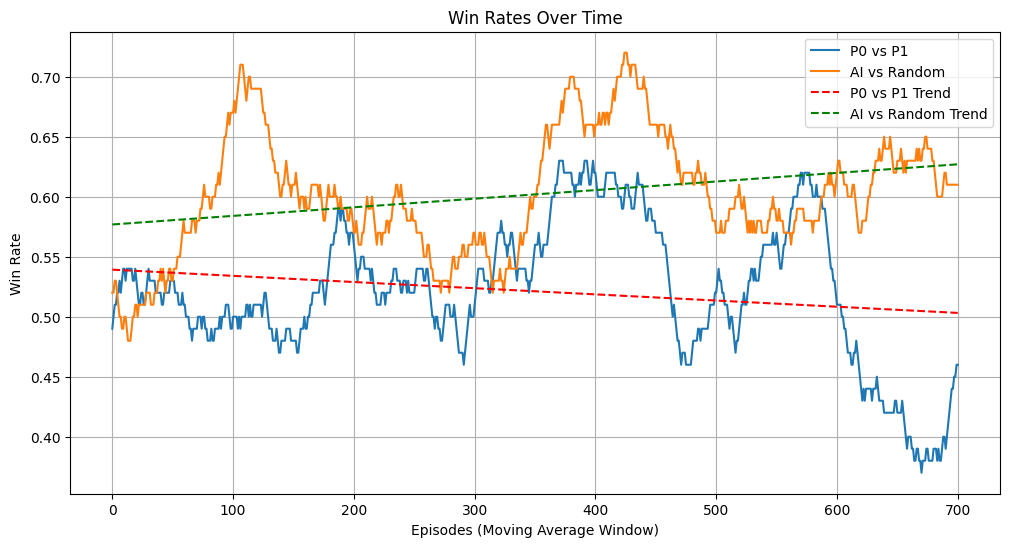

Recent win rate against random: 0.61
Episode 1200: Training in progress...


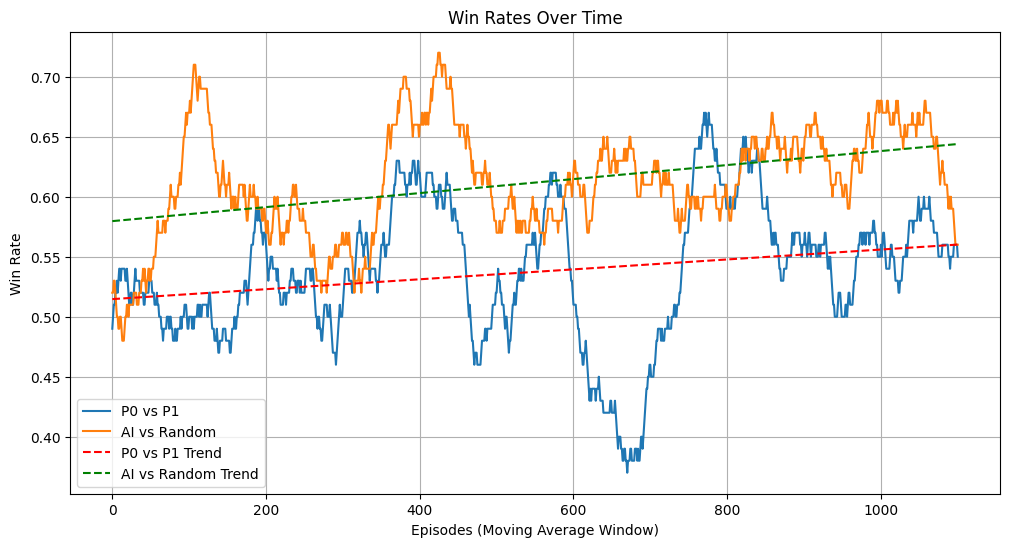

Recent win rate against random: 0.62
Episode 1600: Training in progress...


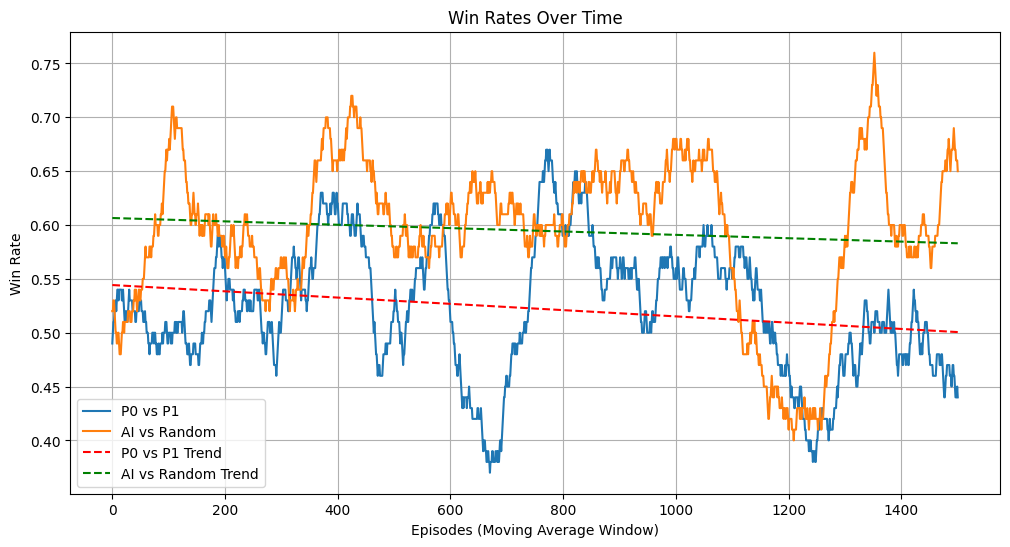

Recent win rate against random: 0.56
Episode 2000: Training in progress...


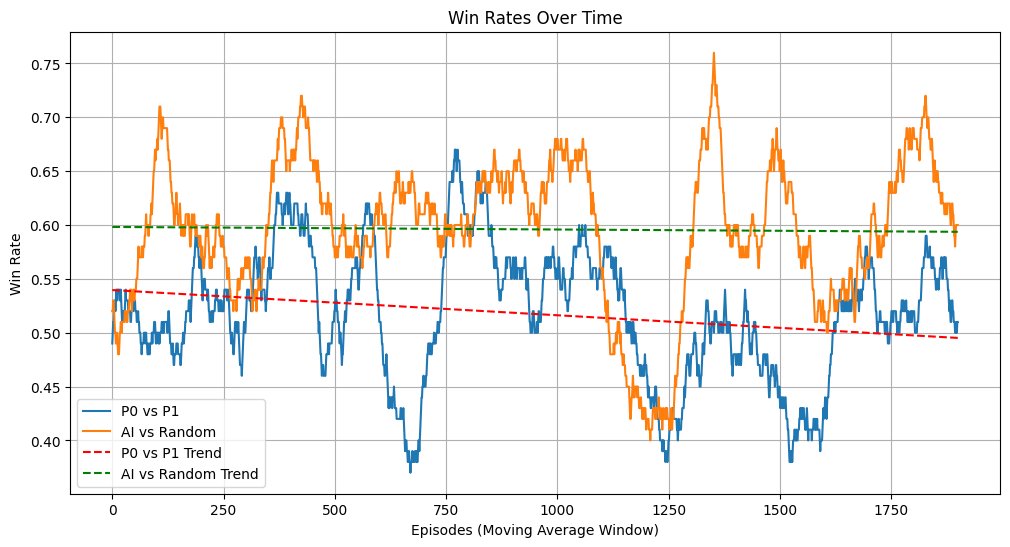

Recent win rate against random: 0.59
Episode 2400: Training in progress...


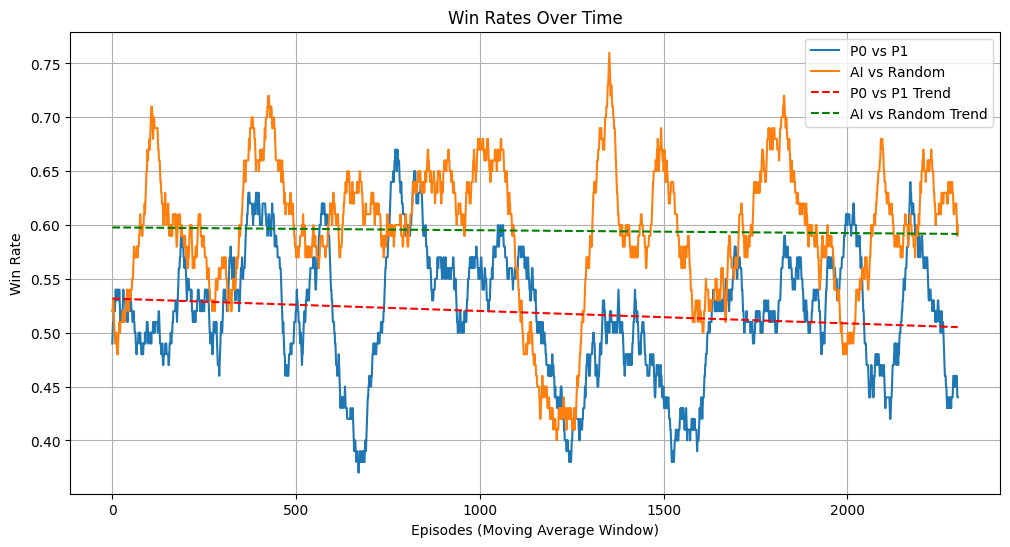

Recent win rate against random: 0.59
Episode 2800: Training in progress...


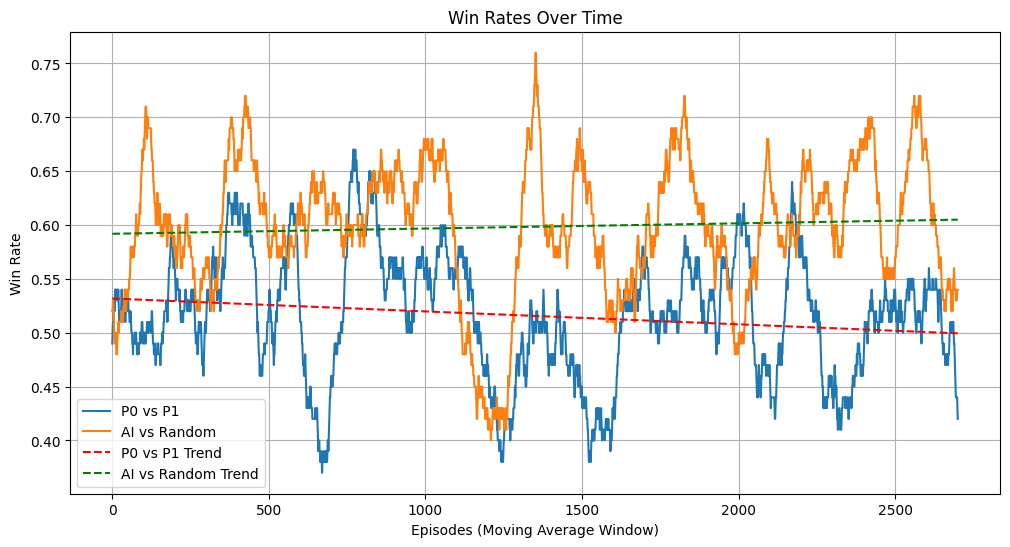

Recent win rate against random: 0.61
Episode 3200: Training in progress...


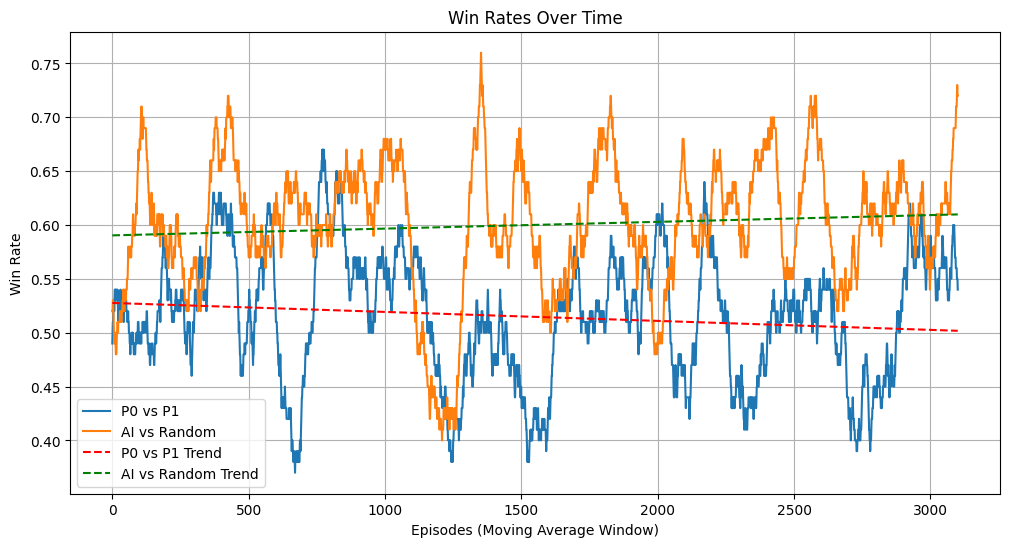

Recent win rate against random: 0.64
Episode 3600: Training in progress...


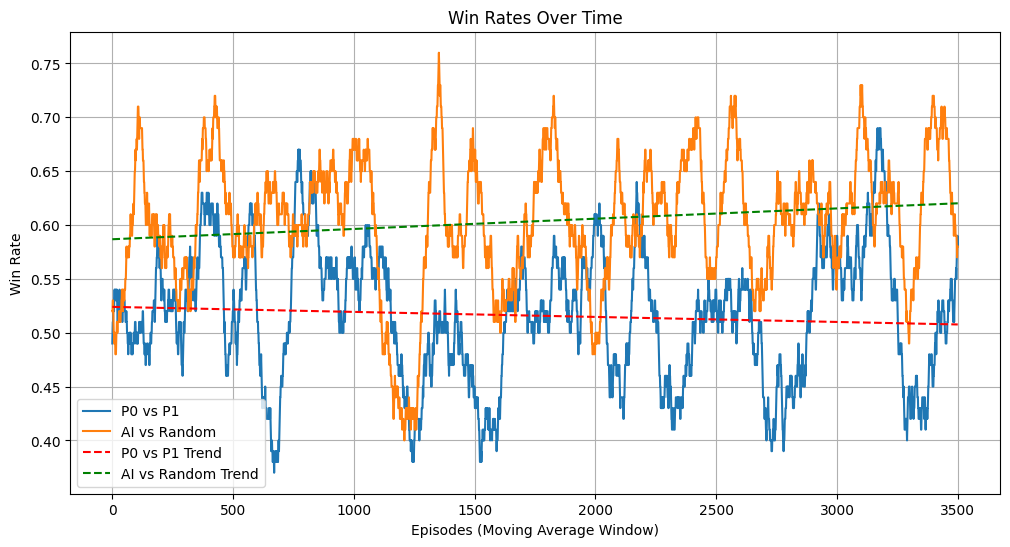

Recent win rate against random: 0.61
Episode 4000: Training in progress...


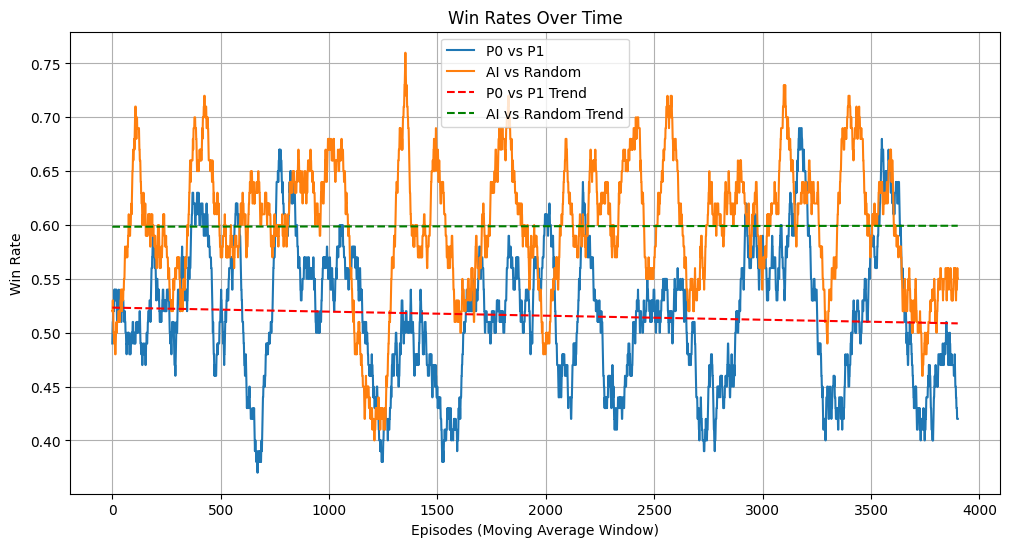

Recent win rate against random: 0.56
Episode 4400: Training in progress...


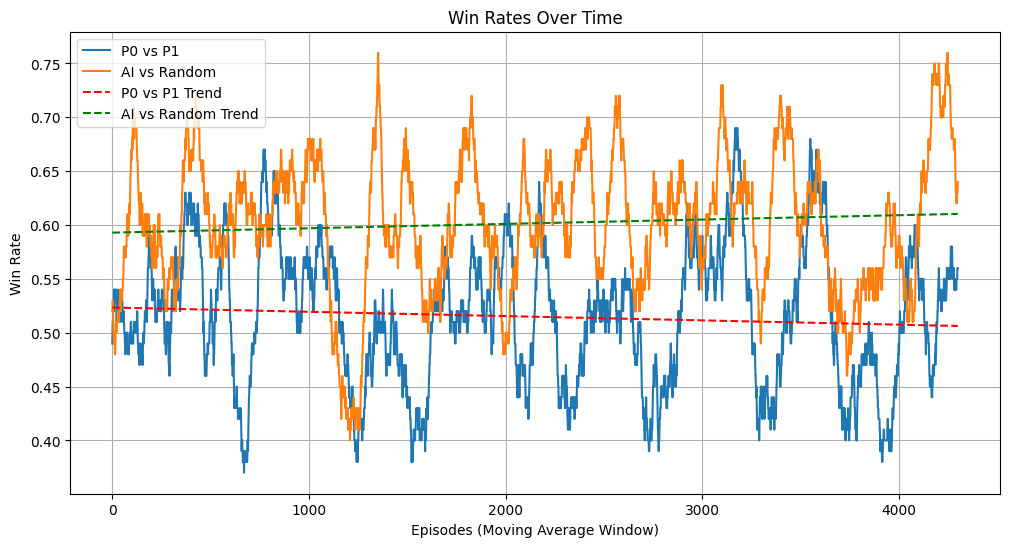

Recent win rate against random: 0.64
Episode 4800: Training in progress...


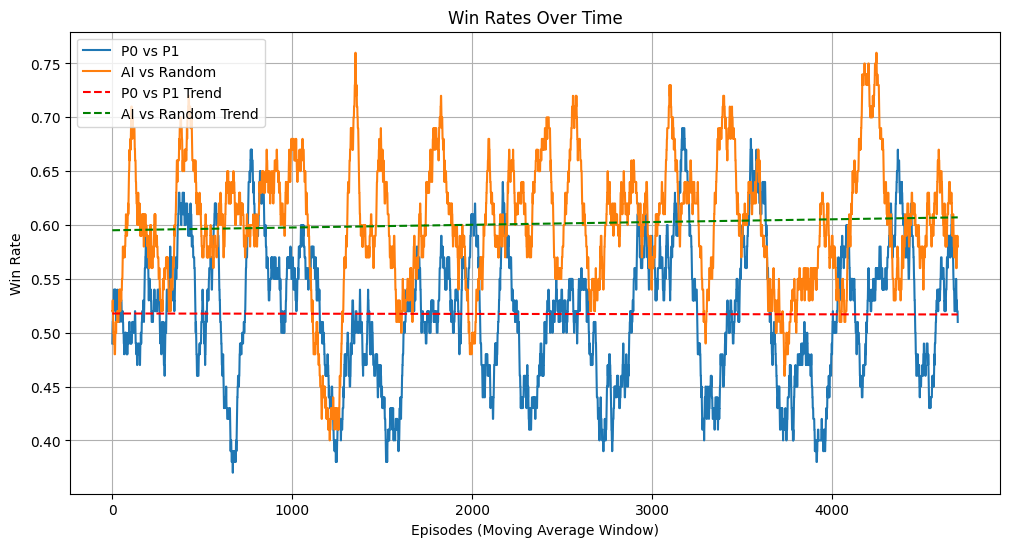

Recent win rate against random: 0.59
Episode 5200: Training in progress...


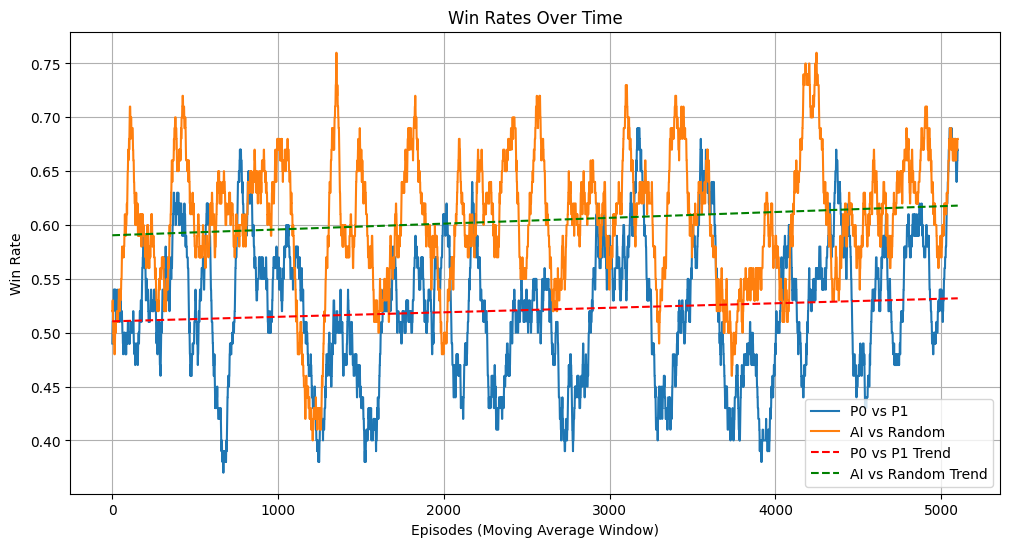

Recent win rate against random: 0.65
Episode 5600: Training in progress...


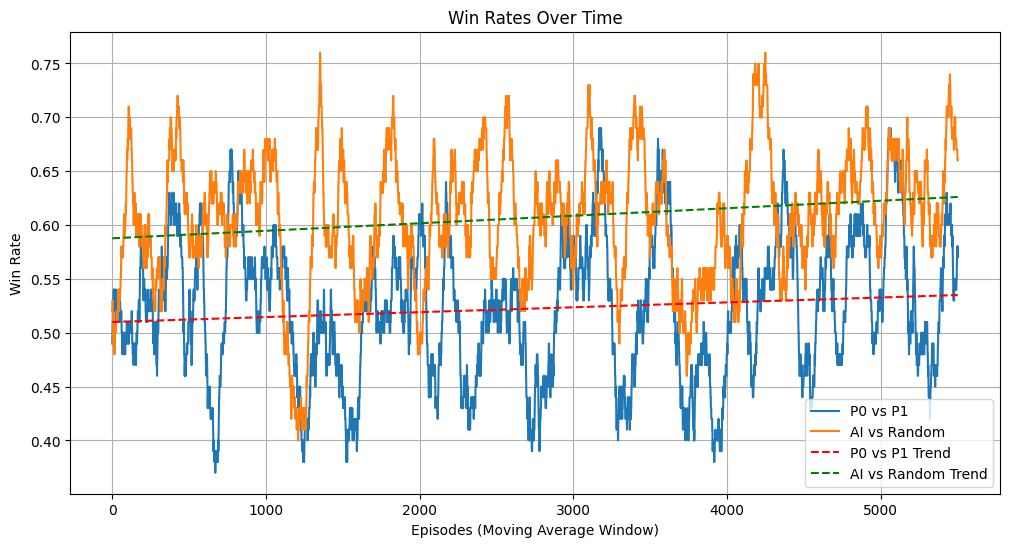

Recent win rate against random: 0.63
Episode 6000: Training in progress...


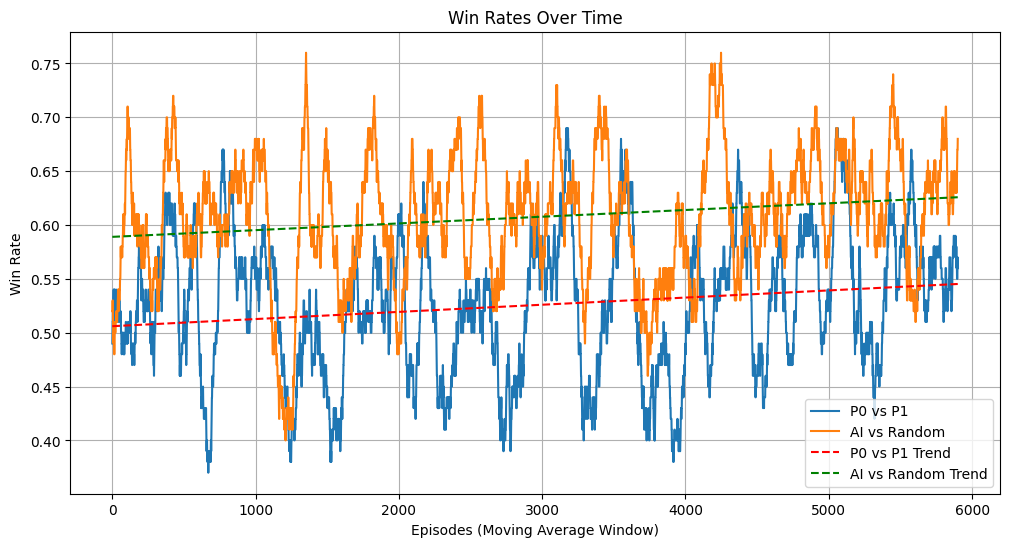

Recent win rate against random: 0.63
Episode 6400: Training in progress...


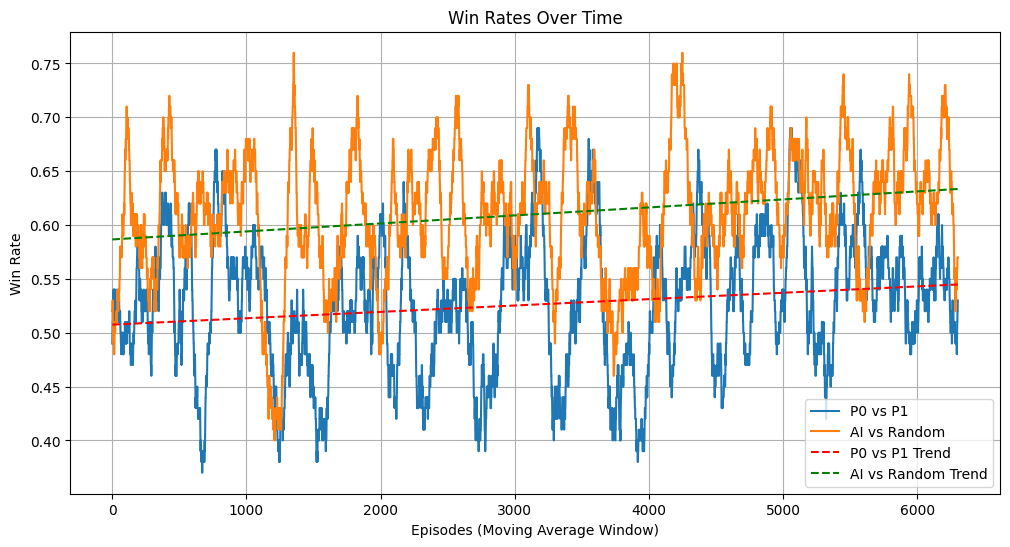

Recent win rate against random: 0.63
Episode 6800: Training in progress...


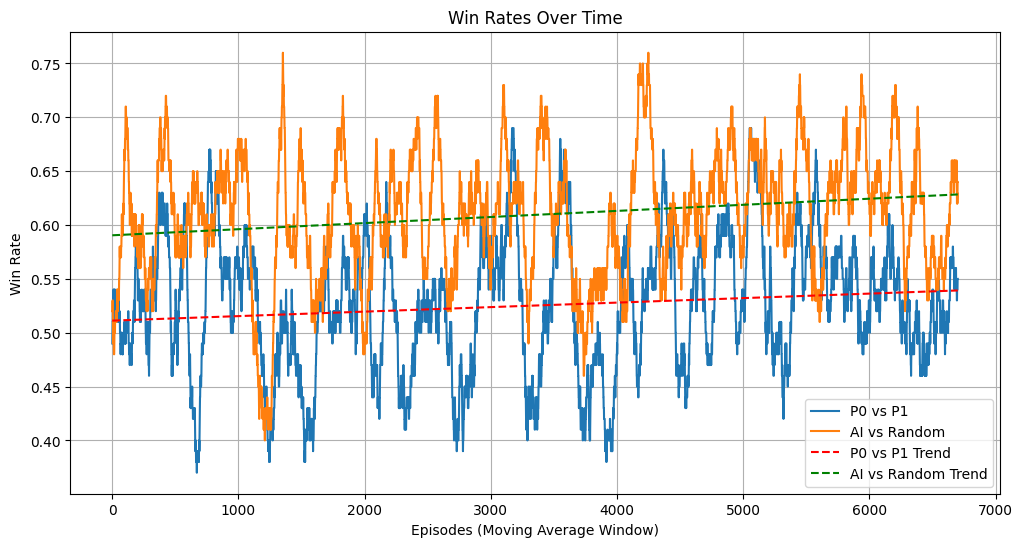

Recent win rate against random: 0.61
Episode 7200: Training in progress...


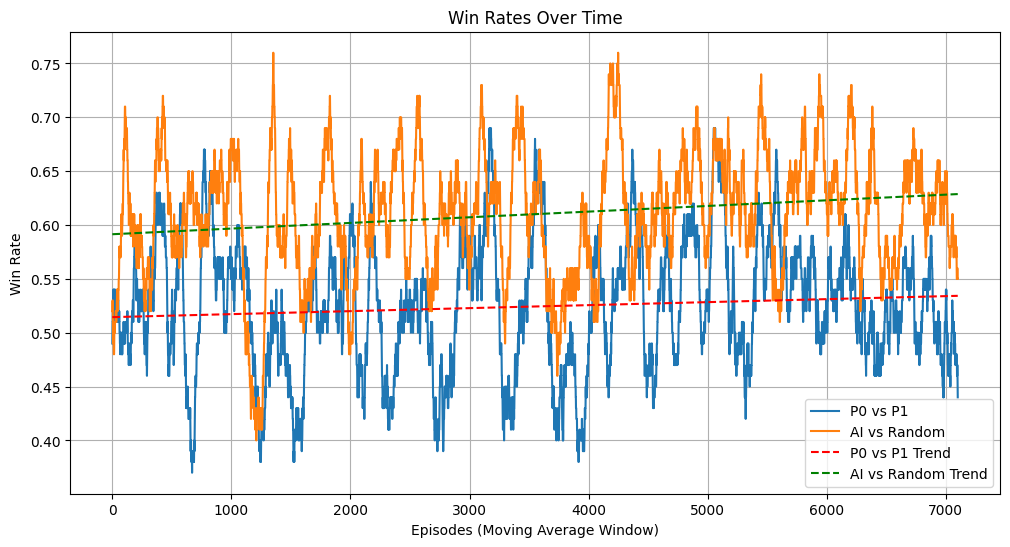

Recent win rate against random: 0.61
Episode 7600: Training in progress...


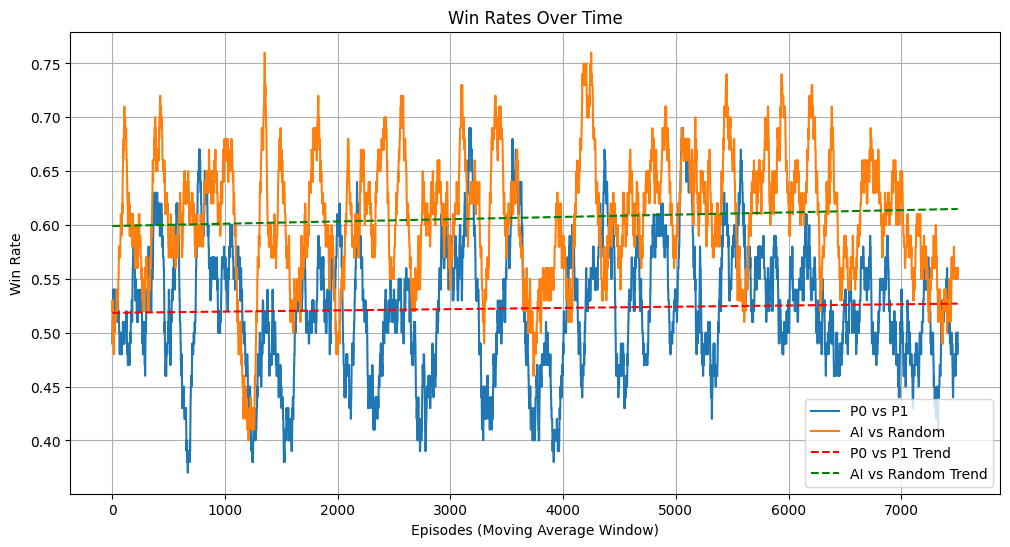

Recent win rate against random: 0.56
Episode 8000: Training in progress...


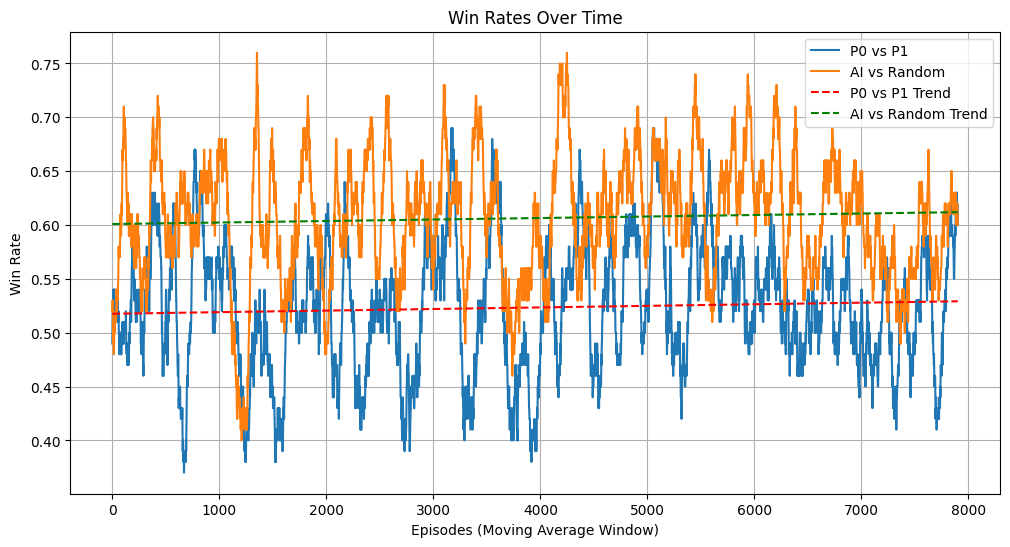

Recent win rate against random: 0.60
Episode 8400: Training in progress...


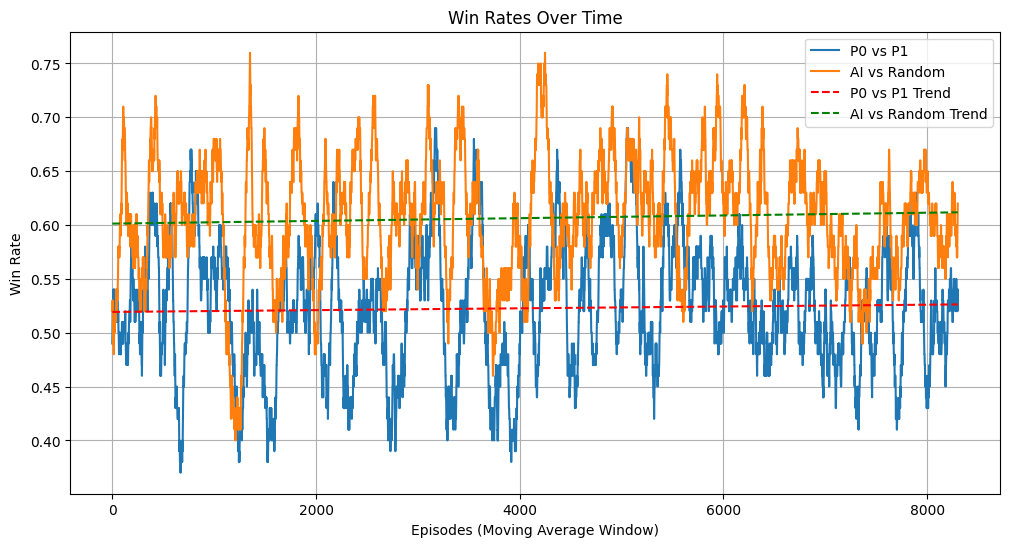

Recent win rate against random: 0.61
Episode 8800: Training in progress...


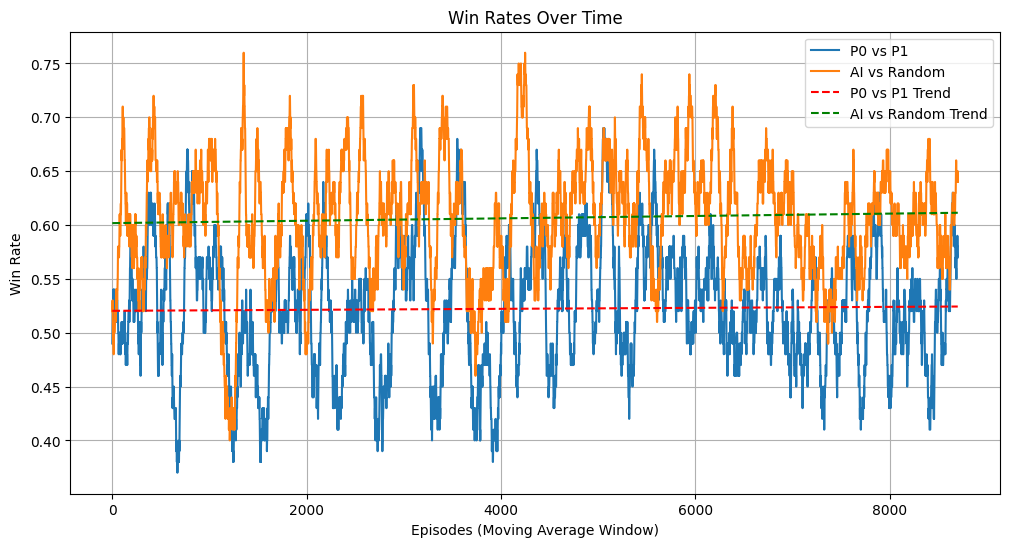

Recent win rate against random: 0.61
Episode 9200: Training in progress...


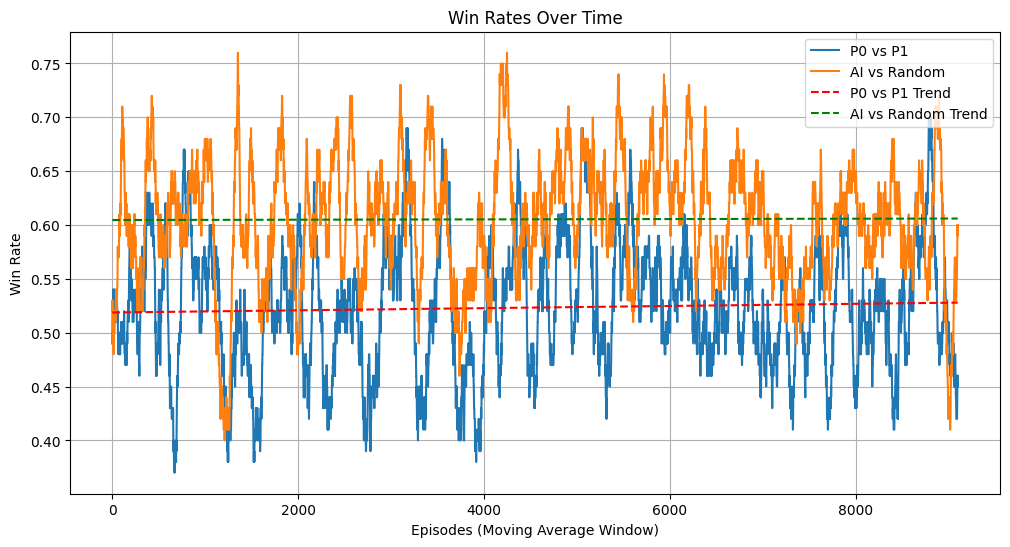

Recent win rate against random: 0.57
Episode 9600: Training in progress...


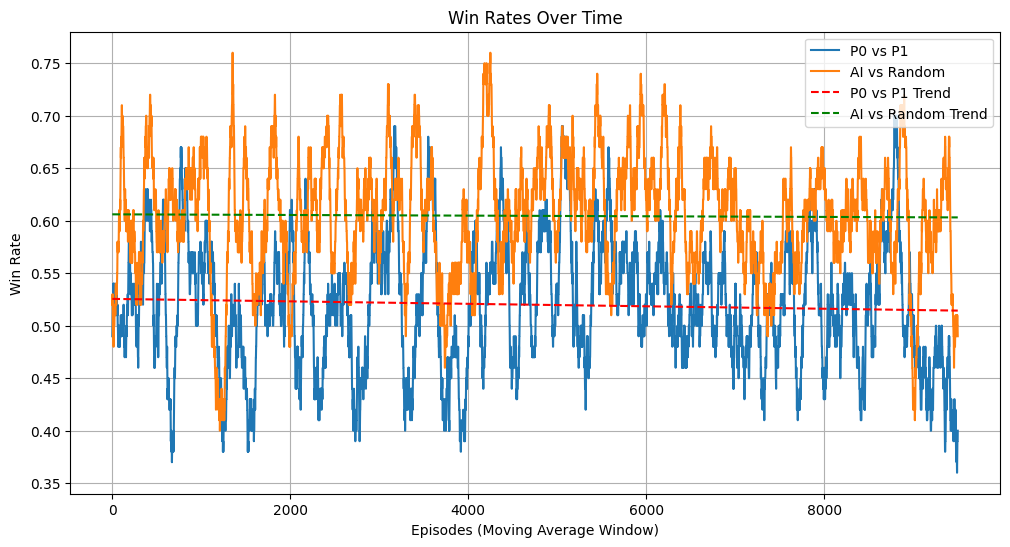

Recent win rate against random: 0.58
Episode 10000: Training in progress...


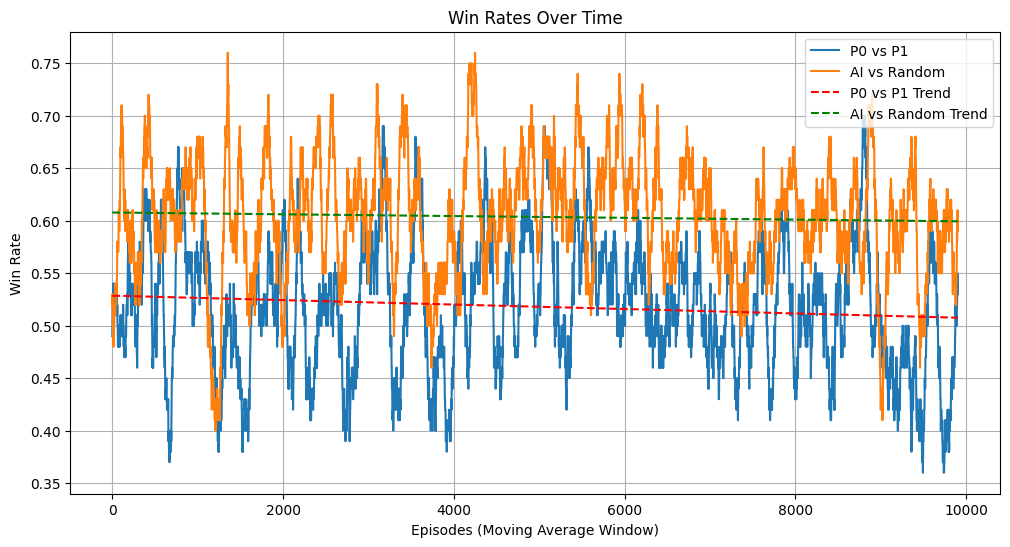

Recent win rate against random: 0.59
Total win rate against random: 0.6035
Training complete.
Initial alpha: 0.6000, Initial epsilon: 0.4000, Initial gamma: 0.8000
Final alpha: 0.6000, Final epsilon: 0.4000, Final gamma: 0.8000


In [157]:
class QLearningAgent:
    def __init__(self, env, alpha=0.6, gamma=0.8, epsilon=0.4):
        self.env = env
        self.q_table = [
            np.zeros((env.size, env.size, 10, 2)),  # Player 0's Q-table
            np.zeros((env.size, env.size, 10, 2))   # Player 1's Q-table
            ]
        self.alpha = alpha # Learning rate, determines to what extent newly acquired information overrides old information
        self.gamma = gamma # Discount factor, determines the importance of future rewards
        self.epsilon = epsilon # Exploration rate, determines the probability of choosing a random action
        self.rewards = []
        self.p0_wins = []
        self.wins_against_random = []


    def select_action(self, state, player):
        # Debug: Print the current state
        # print(f"\nCurrent state for player {player}:")
        # self.env.render()

        # Determine legal actions
        if np.random.rand() < self.epsilon:
            # Random exploration
            legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        else:
            # Exploitation
            legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
             
        # Debug: Print the legal actions available
        # print(f"Legal actions for player {player}: {legal_actions}")

        if not legal_actions:
            raise ValueError(f"No legal actions available for player {player} in state: {state}")

        # Check if we need to perform exploitation
        if np.random.rand() >= self.epsilon and legal_actions:
            action_q_values = []
            for a in legal_actions:
                action_index = a[0]
                if 0 <= action_index < self.q_table[player].shape[2]:
                    q_value = self.q_table[player][state[0], state[1], action_index, player]
                    action_q_values.append(np.max(q_value))
                    #print(f"Q-value for action {a}: {q_value}")
                else:
                    action_q_values.append(float('-inf'))

            max_q_value_index = np.argmax(action_q_values)
            action = legal_actions[max_q_value_index]
        else:
            action = legal_actions[np.random.choice(len(legal_actions))]

        # Debug: Print the chosen action
        # action_name = ACTION_NAMES.get(action[0], "Unknown Action")
        # print(f"Chosen action for player {player}: {action_name} (Raw action: {action})")
        
        return action


    def update(self, state, action, reward, next_state, player):
        q_value = self.q_table[player][state[0], state[1], action[0], player]
        max_next_q_value = np.max(self.q_table[player][next_state[0], next_state[1], :, player])

        # Update rule
        self.q_table[player][state[0], state[1], action[0], player] = q_value + self.alpha * (reward + self.gamma * max_next_q_value - q_value)


        # Debug: Print the Q-value update
        #  print(f"Updated Q-value for player {player}, state {state}, action {action}: {self.q_table[player][state[0], state[1], action[0], player]}")

    def plot_average_reward(self, window_size=100):
        if len(self.rewards) < window_size:
            print("Not enough data to plot average reward")
            return
        avg_rewards = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(avg_rewards)
        plt.title('Average Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.show()

    def plot_win_rate(self, window_size=100):
        if len(self.wins) < window_size:
            print("Not enough data to plot win rate")
            return
        win_rate = np.convolve(self.wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_q_value_heatmap(self, player, action):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.q_table[player][:, :, action, player], annot=True, cmap='YlGnBu')
        plt.title(f'Q-values for Player {player}, Action {action}')
        plt.xlabel('Y coordinate')
        plt.ylabel('X coordinate')
        plt.show()

    def plot_q_value_distribution(self):
        plt.figure(figsize=(10, 6))
        q_values = self.q_table[0].flatten()
        plt.hist(q_values, bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
        plt.title('Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.show()

    def plot_action_preference(self, player):
        preferred_actions = np.argmax(self.q_table[player], axis=2)
        plt.figure(figsize=(10, 8))
        sns.heatmap(preferred_actions[:, :, player], annot=True, cmap='YlGnBu')
        plt.title(f'Preferred Actions for Player {player}')
        plt.xlabel('Y coordinate')
        plt.ylabel('X coordinate')
        plt.show()

    def plot_random_agent_win_rate(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(10, len(self.random_agent_win_rates) * 10 + 1, 10), self.random_agent_win_rates)
        plt.title('Win Rate Against Random Agent')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.ylim(0, 1)
        plt.show()

    def plot_win_rates_with_trend(self):
        plt.figure(figsize=(12, 6))
        
        # AI vs AI win rate
        p0_win_rate = self.calculate_moving_average(self.p0_wins)
        plt.plot(p0_win_rate, label='P0 vs P1')
        
        # AI vs Random win rate
        ai_vs_random_win_rate = self.calculate_moving_average(self.wins_against_random)
        plt.plot(ai_vs_random_win_rate, label='AI vs Random')
        
        # Add trend lines
        x = np.arange(len(p0_win_rate))
        
        # AI vs AI trend line
        z_ai = np.polyfit(x, p0_win_rate, 1)
        p_ai = np.poly1d(z_ai)
        plt.plot(x, p_ai(x), "r--", label='P0 vs P1 Trend')
        
        # AI vs Random trend line
        z_random = np.polyfit(x, ai_vs_random_win_rate, 1)
        p_random = np.poly1d(z_random)
        plt.plot(x, p_random(x), "g--", label='AI vs Random Trend')
        
        plt.title('Win Rates Over Time')
        plt.xlabel('Episodes (Moving Average Window)')
        plt.ylabel('Win Rate')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def calculate_moving_average(self, data, window_size=100):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def evaluate_against_random(self, num_games):
        wins = 0
        for _ in range(num_games):
            state = self.env.reset()
            done = False
            player = 0
            while done > 1:
                if player == 0:
                    action = self.select_action(state, player)
                else:
                    action = self.random_agent(state, player)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                player = 1 - player
            if done == 0:
                wins += 1
        win_rate = wins / num_games
        print(f"Win rate against random agent: {win_rate:.2f}")
        return win_rate


    def plot_results(self):
        #self.plot_average_reward()
        #self.plot_average_reward()
        #self.plot_win_rate()
        self.plot_win_rates_with_trend()
        '''
        self.plot_q_value_heatmap(0, 0)
        self.plot_q_value_heatmap(0, 1)
        self.plot_q_value_heatmap(0, 2)
        self.plot_q_value_heatmap(0, 3)
        self.plot_q_value_heatmap(0, 4)
        self.plot_q_value_heatmap(0, 5)
        self.plot_q_value_distribution()
        self.plot_action_preference(0)'''

    def plot_ai_vs_ai_win_rate(self, window_size=100):
        if len(self.ai_vs_ai_wins) < window_size:
            print("Not enough data to plot AI vs AI win rate")
            return
        win_rate = np.convolve(self.ai_vs_ai_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs AI Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_ai_vs_random_win_rate(self, window_size=100):
        if len(self.ai_vs_random_wins) < window_size:
            print("Not enough data to plot AI vs Random win rate")
            return
        win_rate = np.convolve(self.ai_vs_random_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs Random Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()
        
    def train(self, episodes, eval_interval=500):
        initial_alpha = self.alpha
        initial_epsilon = self.epsilon
        initial_gamma = self.gamma
        
        for episode in range(episodes):
            # AI vs AI game
            state = self.env.reset()
            done = 2
            player = 0
            episode_reward = 0
            while done > 1:
                action = self.select_action(state, player)
                next_state, reward, done, _ = self.env.step(action)
                self.update(state, action, reward, next_state, player)
                state = next_state
                player = 1 - player
                episode_reward += reward
            self.rewards.append(episode_reward)
            self.p0_wins.append(1 if done == 0 else 0)

            # AI vs Random game
            ai_wins = self.play_against_random()
            self.wins_against_random.append(1 if ai_wins == 0 else 0)
            
            if (episode + 1) % eval_interval == 0:
                print(f"Episode {episode + 1}: Training in progress...")

                self.plot_results()
                
                # Calculate recent win rate against random
                recent_win_rate = sum(self.wins_against_random[-eval_interval:]) / eval_interval
                
                
                print(f"Recent win rate against random: {recent_win_rate:.2f}")

        print(f"Total win rate against random: {sum(self.wins_against_random)/episodes}")

        print("Training complete.")
        print(f"Initial alpha: {initial_alpha:.4f}, Initial epsilon: {initial_epsilon:.4f}, Initial gamma: {initial_gamma:.4f}")
        print(f"Final alpha: {self.alpha:.4f}, Final epsilon: {self.epsilon:.4f}, Final gamma: {self.gamma:.4f}")


    def plot_ai_vs_ai_win_rate(self, window_size=100):
        if len(self.ai_vs_ai_wins) < window_size:
            print("Not enough data to plot AI vs AI win rate")
            return
        win_rate = np.convolve(self.ai_vs_ai_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs AI Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_ai_vs_random_win_rate(self, window_size=100):
        if len(self.ai_vs_random_wins) < window_size:
            print("Not enough data to plot AI vs Random win rate")
            return
        win_rate = np.convolve(self.ai_vs_random_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs Random Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def play(self):
        state = self.env.reset()
        done = False
        player = 0

        while not done:
            action = self.select_action(state, player)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            player = 1 - player

        print("Game over.")

    def random_agent(self, state, player):
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        return legal_actions[np.random.randint(len(legal_actions))]

    def get_human_action(self, state, player):
        self.env.render()
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        
        print("\nLegal actions:")
        for i, action in enumerate(legal_actions):
            action_name = ACTION_NAMES[action[0]]
            print(f"{i}: {action_name} at position ({action[1]}, {action[2]})")
        
        while True:
            try:
                choice = int(input("\nEnter the number of your chosen action: "))
                if 0 <= choice < len(legal_actions):
                    return legal_actions[choice]
                else:
                    print("Invalid choice. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    def play_against_human(self):
        state = self.env.reset()
        done = False
        player = 0  # 0 for human, 1 for AI

        while not done:
            if player == 0:
                action = self.get_human_action(state, player)
            else:
                action = self.select_action(state, player)
                print(f"\nAI chose action: {ACTION_NAMES[action[0]]} at position ({action[1]}, {action[2]})")

            next_state, reward, done, _ = self.env.step(action)
            print("reward ",reward)
            state = next_state
            player = 1 - player

        self.env.render()
        if reward > 0:
            print("You win!")
        elif reward < 0:
            print("AI wins!")
        else:
            print("It's a draw!")

    def play_against_random(self):
        state = self.env.reset()
        done = 2
        player = 0
        while done > 1:
            if player == 0:
                action = self.select_action(state, player)
            else:
                legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
                action = legal_actions[np.random.randint(len(legal_actions))]
            next_state, reward, done, _ = self.env.step(action)
            state = next_state
            player = 1 - player
        return done  

# Initialize the environment
env = GhostsEnv()


agent = QLearningAgent(env)
agent.train(episodes=10000, eval_interval=400)

In [158]:

# Play against the trained AI
while True:
    play_again = input("Do you want to play against the AI? (yes/no): ").lower()
    if play_again != 'yes':
        break
    agent.play_against_human()

print("Thanks for playing!")



 0 1 2 3 4 5
0 . . . . . .
1 . . . . . .
2 . . . . . .
3 . . . . . .
4 . . . . . .
5 . . . . . .


Legal actions:
0: Place Blue Piece at position (4, 1)
1: Place Blue Piece at position (4, 2)
2: Place Blue Piece at position (4, 3)
3: Place Blue Piece at position (4, 4)
4: Place Blue Piece at position (5, 1)
5: Place Blue Piece at position (5, 2)
6: Place Blue Piece at position (5, 3)
7: Place Blue Piece at position (5, 4)
8: Place Red Piece at position (4, 1)
9: Place Red Piece at position (4, 2)
10: Place Red Piece at position (4, 3)
11: Place Red Piece at position (4, 4)
12: Place Red Piece at position (5, 1)
13: Place Red Piece at position (5, 2)
14: Place Red Piece at position (5, 3)
15: Place Red Piece at position (5, 4)
Invalid input. Please enter a number.
Invalid input. Please enter a number.
Invalid input. Please enter a number.
Invalid input. Please enter a number.
Invalid input. Please enter a number.


KeyboardInterrupt: Interrupted by user

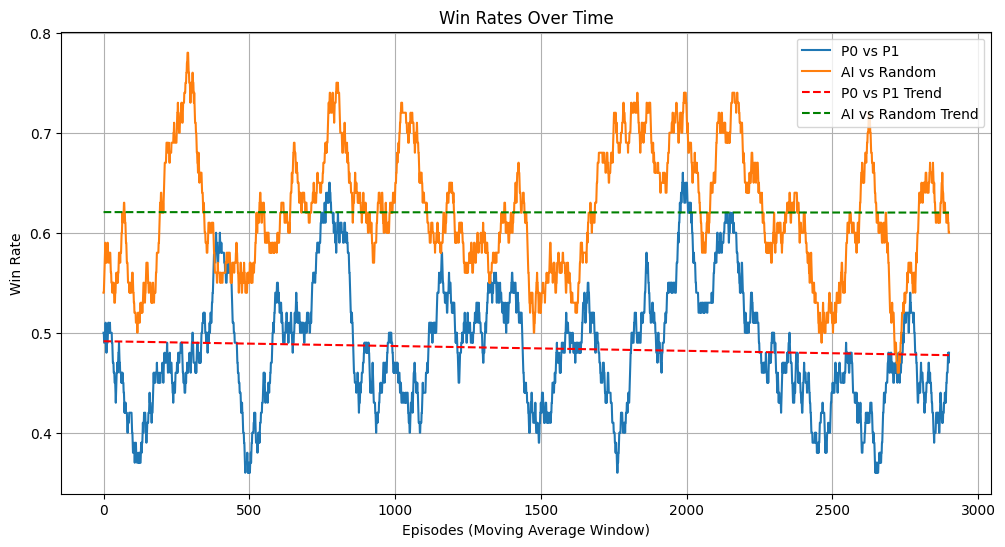

In [139]:
agent.plot_results()